In [1]:
import getpass
import os
import torch
import numpy as np
from PIL import Image
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import torch.nn.functional as F
#from skimage import transform
import sys
from sklearn.metrics import roc_curve, auc
import copy
import torchvision.models as models
import re
import xml.etree.ElementTree as ET
import cv2
#from display import read_image, draw_boxes, draw_grid, draw_text
#import display

In [2]:
# with this function you set the value of the environment variable CUDA_VISIBLE_DEVICES
# to set which GPU to use
# it also reserves this amount of memory for your exclusive use. This might be important for 
# not having other people using the resources you need in shared systems
# the homework was tested in a GPU with 4GB of memory, and running this function will require at least
# as much
# if you want to test in a GPU with less memory, you can call this function
# with the argument minimum_memory_mb specifying how much memory from the GPU you want to reserve
def define_gpu_to_use(minimum_memory_mb = 3800):
    gpu_to_use = None
    try: 
        os.environ['CUDA_VISIBLE_DEVICES']
        print('GPU already assigned before: ' + str(os.environ['CUDA_VISIBLE_DEVICES']))
        return
    except:
        pass
    torch.cuda.empty_cache()
    for i in range(16):
        free_memory = !nvidia-smi --query-gpu=memory.free -i $i --format=csv,nounits,noheader
        if free_memory[0] == 'No devices were found':
            break
        free_memory = int(free_memory[0])
        if free_memory>minimum_memory_mb-500:
            gpu_to_use = i
            break
    if gpu_to_use is None:
        print('Could not find any GPU available with the required free memory of ' +str(minimum_memory_mb) + 'MB. Please use a different system for this assignment.')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_to_use)
        print('Chosen GPU: ' + str(gpu_to_use))
        x = torch.rand((256,1024,minimum_memory_mb-500)).cuda()
        x = torch.rand((1,1)).cuda()
        del x
define_gpu_to_use()

Could not find any GPU available with the required free memory of 3800MB. Please use a different system for this assignment.


In [3]:
def load_raw_images(image_size=256, batch_size=64, root="../leafDataForBoudingBox/"):

    transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_set = torchvision.datasets.ImageFolder(root=root, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

    return train_loader    
train_loader = load_raw_images()

In [4]:
def read_image(image, size):
    img = cv2.imread(image, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (size, size))
    return img

In [5]:
def draw_boxes(image, boxes_list):
    for boxes in boxes_list:
        cv2.rectangle(image, (int(boxes[0]-boxes[2]/2),int(boxes[1]-boxes[3]/2)),(int(boxes[0]+boxes[2]/2),int(boxes[1]+boxes[3]/2)),(0,0,255),2)
    return image

In [6]:
def draw_grid(img, pixel_step):
    x = pixel_step
    y = pixel_step

    while x < img.shape[1]:
        cv2.line(img, (x, 0), (x, img.shape[0]), color=(255, 255, 255))
        x += pixel_step

    while y < img.shape[0]:
        cv2.line(img, (0, y), (img.shape[1], y), color=(255, 255, 255))
        y += pixel_step

    return img

In [7]:
def draw_text(img, text_list, location):
    for text,loc in zip(text_list, location):
        cv2.putText(img, text, (int(loc[0]), int(loc[1])), cv2.FONT_HERSHEY_COMPLEX,0.5, (255, 0, 0), 1)
    return img

In [8]:
def img_normalize(image):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    img = normalize(torch.from_numpy(image))
    return img.numpy()

def preprocess(img, min_size=600, max_size=1000):
    C,H,W = img.shape
    scale1 = min_size/min(H,W)
    scale2 = max_size/max(H,W)
    scale = min(scale1, scale2)
    img = img/255
    img = transform.resize(img, (C,H*scale, W*scale), mode='reflect', anti_aliasing=False)
    normalize = img_normalize
    return normalize(img)

In [9]:
class CropBiggestCenteredInscribedSquare(object):
    def __init__(self):
        pass

    def __call__(self, tensor):
        longer_side = min(tensor.size)
        horizontal_padding = (longer_side - tensor.size[0]) / 2
        vertical_padding = (longer_side - tensor.size[1]) / 2
        return tensor.crop(
            (
                -horizontal_padding,
                -vertical_padding,
                tensor.size[0] + horizontal_padding,
                tensor.size[1] + vertical_padding
            )
        )

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [18]:
def split_data(image_name_list, split_type):
    np.random.seed(31)
    np.random.shuffle(image_name_list)
    np.random.seed()
    if split_type == 'train':
        image_name_list = image_name_list[:int(len(image_name_list)*0.6)]
    elif split_type == 'validate':
        image_name_list = image_name_list[int(len(image_name_list)*0.6):int(len(image_name_list)*0.8)]
    elif split_type== 'test':
        image_name_list = image_name_list[int(len(image_name_list)*0.8):]
    return image_name_list

In [75]:
class plant_leaf_disease_dataset(Dataset):
    def __init__(self, data_dir_bounding_box,data_dir_images,split="train"):
        self.data_dir_bounding_box = data_dir_bounding_box
        self.data_dir_images = data_dir_images
        self.grid_size=14
        self.label_names = ['AppleScab','CedarAppleRust','CherryPowderyMildew','FrogEyeSpot','CherrySourPowderyMildew','CornMaizeCercosporaGrayLeafSpot','CornMaizeCommonRust','CornMaizeHealthy','CornMaizeNorthernLeafBlight','GrapeBlackRot','GrapeEscaBlackMeasles','GrapeLeafBlightIsariopsis','OrangeHaungLongbingCitrus','PeachBacterialSpot','PepperBellBacterialSpot','PotatoEarlyBlight','PotatoLateBlight','SquashPowderyMildew','StrawberryLeafScorch','TomatoBacterialSpot','TomatoEarlyBlight','TomatoLateBlight','TomatoLeafMold','TomatoSeptoriaLeafSpot','TomatoSpiderMitesTwoSpotted','TomatoTargetSpot','TomatoMosaicVirus','TomatoYellowLeafCurlVirus']
        columns=['image_name','label','bounding_boxes', 'new_bounding_boxes','xmin','ymin','xmax','ymax']
        combined_dataset = []
        for subdir, dirs, files in os.walk(self.data_dir_bounding_box):
            for file in files:
                #print (file)
                bounding_box, label_name, image_name=self.get_example(file) #ordering xmin, ymin, xmax, ymax
                new_bounding_box = self.convert_to_center(bounding_box)
                #print (bounding_box)
                record_data = [image_name, label_name, bounding_box, new_bounding_box, bounding_box[:,0], bounding_box[:,1],bounding_box[:,2], bounding_box[:,3]]
                combined_dataset.append(record_data)
        self.dataset_df = pd.DataFrame(combined_dataset, columns = columns)
        self.dataset_df['grid_boxes'] = self.dataset_df['bounding_boxes'].apply(lambda x:self.grid_formation(x))
        image_name_list = pd.unique(self.dataset_df['image_name'])
        splitted_data = split_data(image_name_list,split)
        image_name_list = pd.DataFrame(splitted_data,columns=['image_name'])
        subset_data = pd.merge(image_name_list,self.dataset_df)
        self.dataset_df = subset_data
        self.images = self.dataset_df['image_name'].values
        self.targets = self.dataset_df['label'].values
        self.bounding_boxes = self.dataset_df['bounding_boxes'].values
        self.grid_boxes = self.dataset_df['grid_boxes'].values
        self.new_bounding_boxes = self.dataset_df['new_bounding_boxes'].values
        print (len(self.dataset_df))
        #print (self.dataset_df.head())    
        #print (self.grid_boxes[0].shape)
    
    def grid_formation(self,b_boxes):
        img_original_size=256
        grid_mat = torch.zeros([1,1,img_original_size, img_original_size],dtype=torch.float)
        #print (b_boxes.shape)
        for b_box in b_boxes:
            #print (b_box[1,:].item())
            y1= int(b_box[1,:].item())
            y2=int(b_box[3,:].item())
            x1=int(b_box[0,:].item())
            x2=int(b_box[2,:].item())
            
            grid_mat[:,:,y1:y2,x1:x2] = 1.0
        first_resize_size = (img_original_size//self.grid_size)*self.grid_size
        grid_mat = torch.nn.functional.interpolate(grid_mat, size = (first_resize_size, first_resize_size), mode = 'bilinear', align_corners = False)
        grid_mat = torch.nn.AvgPool2d(kernel_size = img_original_size//self.grid_size)(grid_mat)
        grid_mat = ((grid_mat[0,:,:,:][:]>0.5)*1.0).float()
        return grid_mat
    
    def convert_to_center(self, b_boxes):
        new_box=[]
        for b_box in b_boxes:
            cx = b_box[0]+b_box[2]/2
            cy = b_box[1]+b_box[3]/2
            new_box.append([cx,cy,b_box[2], b_box[3]])
        return new_box
        
    def get_example(self,file_name):
        #print ()
        annotate = ET.parse(os.path.join(self.data_dir_bounding_box,re.findall("[a-zA-Z]+",file_name)[0],file_name))
        image_name = annotate.find('filename').text
        #bounding_box = list()
        #label=list()
        for obj in annotate.findall('object'):
            bounding_box_values = obj.find('bndbox')
            bounding_box = [int(bounding_box_values.find(tag).text) for tag in ('xmin','ymin','xmax','ymax')]
            label_name=obj.find('name').text.strip()
            bounding_box = np.vstack(bounding_box)
            bounding_box = torch.from_numpy(bounding_box[None,:,:]).float()
            #print (bounding_box.shape)
            #label.append(label_name)
        #bounding_box = np.stack(bounding_box).astype(np.float32)
        #label = np.stack(label).astype(np.int32) #need to change this
        return bounding_box,label_name, image_name
    
    def __getitem__(self, index):
        set_of_transforms = transforms.Compose(
        [CropBiggestCenteredInscribedSquare(),
         transforms.Resize(224),
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
        image_val = set_of_transforms(Image.open(self.data_dir_images + '/' + self.targets[index]+'/'+ self.images[index]).convert('RGB'))
        return self.images[index],image_val, self.label_names.index(self.targets[index]),self.new_bounding_boxes[index], self.grid_boxes[index]
    
    def __len__(self):
        return len(self.images)        

In [88]:
path_to_bounding_box = "../bounding_box/"
path_to_image_folder = "../leafDataForBoudingBox/"
label_names_dataset = ['AppleScab','CedarAppleRust','CherryPowderyMildew','FrogEyeSpot','CherrySourPowderyMildew','CornMaizeCercosporaGrayLeafSpot','CornMaizeCommonRust','CornMaizeHealthy','CornMaizeNorthernLeafBlight','GrapeBlackRot','GrapeEscaBlackMeasles','GrapeLeafBlightIsariopsis','OrangeHaungLongbingCitrus','PeachBacterialSpot','PepperBellBacterialSpot','PotatoEarlyBlight','PotatoLateBlight','SquashPowderyMildew','StrawberryLeafScorch','TomatoBacterialSpot','TomatoEarlyBlight','TomatoLateBlight','TomatoLeafMold','TomatoSeptoriaLeafSpot','TomatoSpiderMitesTwoSpotted','TomatoTargetSpot','TomatoMosaicVirus','TomatoYellowLeafCurlVirus']
train_dataset = plant_leaf_disease_dataset(path_to_bounding_box,path_to_image_folder)
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle = True, batch_size = 28, num_workers = 3)
validate_dataset = plant_leaf_disease_dataset(path_to_bounding_box,path_to_image_folder,split="validate")
test_dataset = plant_leaf_disease_dataset(path_to_bounding_box,path_to_image_folder,split="test")
#torch..utils.data.DataLoader(dataset,)
validate_loader = torch.utils.data.DataLoader(validate_dataset, shuffle = True, batch_size = 28, num_workers = 3)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle = True, batch_size = 28, num_workers = 3)
print (len(test_dataset))

149
50
50
50


10
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


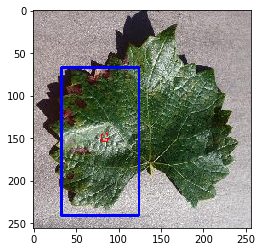

In [89]:
i = train_dataset.__getitem__(3)
img=i[0]
print (i[2])
img = read_image(path_to_image_folder+"/"+label_names_dataset[i[2]]+"/"+img, 256)
img = draw_boxes(img, i[3])
print (i[4])
img = draw_text(img, label_names_dataset[i[2]], i[3])
plt.imshow(img)
plt.show()


In [90]:
class Flatten(torch.nn.Module):
    def forward(self,x):
        x = x.view(x.size()[0],-1)
        return x

In [91]:
def auroc(logits_predicted, target):
    series0, series1, _ = roc_curve(target, logits_predicted)
    return auc(series0, series1)
def get_score(model, data_loader):
    #toggle model to eval mode
    model.eval()
    
    #turn off gradients since they will not be used here
    # this is to make the inference faster
    with torch.no_grad():
        logits_predicted = np.zeros([0, 1])
        targets = np.zeros([0,1])
        
        #run through several batches, does inference for each and store inference results
        # and store both target labels and inferenced scores 
        for i in data_loader:
            image = i[1]
            grid = i[4]
            image = image.cuda()
            logit_predicted = model(image)
            # each grid cell target is considered a different example for calculating the score
            # for that, all outputs and target are reshaped to have only one value in the second dimension
            logits_predicted = np.concatenate((logits_predicted, logit_predicted.view([-1,1]).cpu().numpy()), axis = 0)
            targets = np.concatenate((targets, grid.view([-1,1]).cpu().numpy()), axis = 0)
    return auroc(logits_predicted[:,0], targets[:,0])

In [92]:
main_model_q2 = models.resnet18(pretrained=True)
print (main_model_q2.fc.in_features)
print (main_model_q2.layer3)

main_model_q2 = torch.nn.Sequential(*(list(main_model_q2.children())[:7]))
main_model_q2 = torch.nn.Sequential(main_model_q2, torch.nn.Conv2d(in_channels=256, out_channels=1, kernel_size=1))
cuda_main_model_q2 = main_model_q2.cuda()
print (cuda_main_model_q2)
#print (count_number_parameters(cuda_main_model_q2))

512
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, 

In [93]:
loss_q2 = torch.nn.MultiLabelSoftMarginLoss()
adam_optimizer_q2 = torch.optim.Adam(cuda_main_model_q2.parameters(),lr=0.0001)

In [94]:
num_epochs = 3
for epoch in range(num_epochs):
    cuda_main_model_q2.train()
    loss_list = []
    for i in train_loader:
        image_list = i[1]
        grids = i[4]
        image_list = image_list.cuda()
        grids = grids.cuda()
        #print (grids.shape)
        #print (image_list.shape)
        adam_optimizer_q2.zero_grad()
        predicted_output = cuda_main_model_q2(image_list)
        #print (predicted_output.shape)
        loss = loss_q2(predicted_output, grids)
        loss.backward()
        adam_optimizer_q2.step()
        loss_list.append(loss.item())
    print ("epoch:"+str(epoch))
    print ("Loss:")
    print (sum(loss_list)/len(loss_list))

epoch:0
Loss:
0.720272421836853
epoch:1
Loss:
0.6683695117632548
epoch:2
Loss:
0.6276422739028931


In [95]:
final_auc_score_12 = get_score(cuda_main_model_q2, validate_loader)
print (final_auc_score_12)

0.9077551909936821


In [43]:
final_auc_score_12 = get_score(cuda_main_model_q2, validate_loader)

In [96]:
test_data= torch.utils.data.DataLoader(test_dataset, batch_size = 1, num_workers = 3)

In [98]:
def get_test_set_mistake_image(model, test_set):
    model.eval()
    with torch.no_grad():
        logits_predicted = np.zeros([0,1])
        targets = np.zeros([0,1])
        image_mistake_predicted=[]
        image_mistake_gt=[]
        image_correct = []
        image_correct_gt = []
        count=0
        grid_gt=[]
        for i in test_set:
            image=i[1]
            grid=i[4]
            target=i[2]
            if count>24:
                break
            image = image.cuda()
            logit_predicted = model(image)
            out = torch.sigmoid(logit_predicted).data>0.5
            out = out.cpu().numpy()
            grid=grid.cpu().numpy()
            print ((out==grid).all())
            count+=1
            if (not(out==grid).all()):
                image=image.squeeze()
                out = torch.from_numpy(out)
                out=out.squeeze(0)
                grid = torch.from_numpy(grid)
                grid = grid.squeeze(0)
                image_mistake_predicted.append((image.cpu(), target,out))
                image_mistake_gt.append((image.cpu(), target,grid))
            else:
                image=image.squeeze()
                out = torch.from_numpy(out)
                out=out.squeeze(0)
                grid = torch.from_numpy(grid)
                grid = grid.squeeze()
                image_correct.append((image.cpu(), target, out))
                image_correct_gt.append((image.cpu(), target,grid))
        return image_mistake_predicted,image_mistake_gt, image_correct, image_correct_gt
image_mistake_predicted,image_mistake_gt, image_correct,  image_correct_gt = get_test_set_mistake_image(cuda_main_model_q2, test_data)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [51]:
print ("No. of incorrect predictions from the first 21 examples of test set:"+str(len(image_mistake_predicted)))

No. of incorrect predictions from the first 21 examples of test set:24


In [40]:
def imresize(arr, size, resample):
    return np.array(Image.fromarray(arr).resize(size, resample))
def plot_grid_over_xray(example):
    image = example[0].numpy()[0,:,:]
    print('Label pneumonia: ' + str(example[1][0].cpu().numpy()))
    max1 = np.max(image)
    min1 = np.min(image)
    fig, ax = plt.subplots()
    print (image.shape)
    ax.imshow((image-min1)/(max1 - min1), cmap = 'gray')
    ax.imshow(imresize(example[2].numpy()[0,:,:], (224, 224), resample  = Image.NEAREST), cmap='jet', alpha=0.3, resample = True)
    plt.show()

The following are the visualization of the incorrect prediction followed by the same image with ground truth to see the difference:
Label pneumonia: 10
(256, 256)


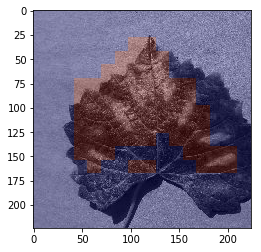

---------------------------------------------------------------------------------------------
Label pneumonia: 10
(256, 256)


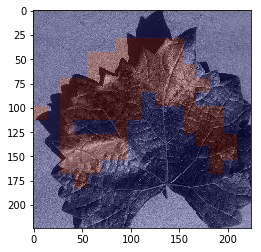

---------------------------------------------------------------------------------------------
Label pneumonia: 10
(256, 256)


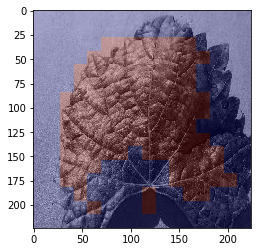

---------------------------------------------------------------------------------------------
Label pneumonia: 11
(256, 256)


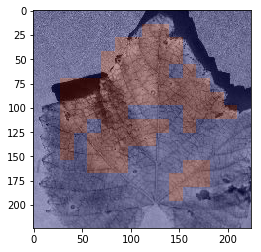

---------------------------------------------------------------------------------------------
Label pneumonia: 10
(256, 256)


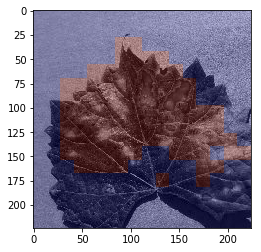

---------------------------------------------------------------------------------------------
Label pneumonia: 11
(256, 256)


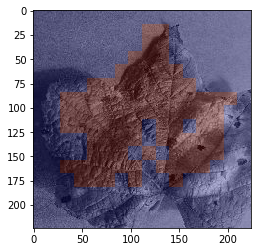

---------------------------------------------------------------------------------------------
Label pneumonia: 10
(256, 256)


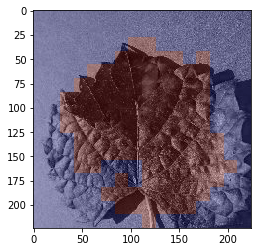

---------------------------------------------------------------------------------------------
Label pneumonia: 10
(256, 256)


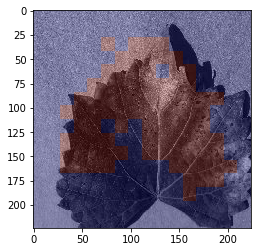

---------------------------------------------------------------------------------------------
Label pneumonia: 10
(256, 256)


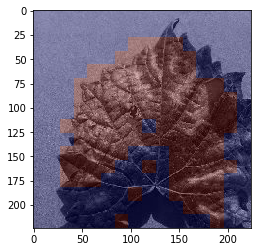

---------------------------------------------------------------------------------------------
Label pneumonia: 11
(256, 256)


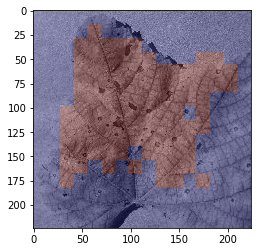

---------------------------------------------------------------------------------------------
Label pneumonia: 11
(256, 256)


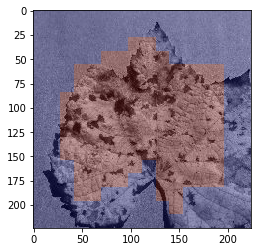

---------------------------------------------------------------------------------------------
Label pneumonia: 10
(256, 256)


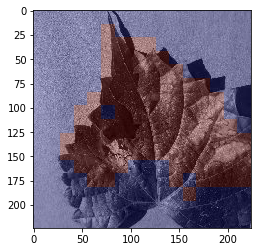

---------------------------------------------------------------------------------------------
Label pneumonia: 11
(256, 256)


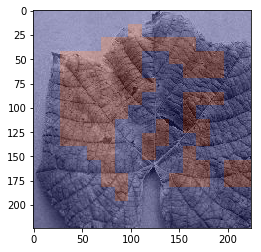

---------------------------------------------------------------------------------------------
Label pneumonia: 11
(256, 256)


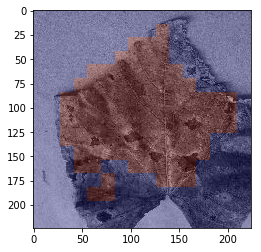

---------------------------------------------------------------------------------------------
Label pneumonia: 11
(256, 256)


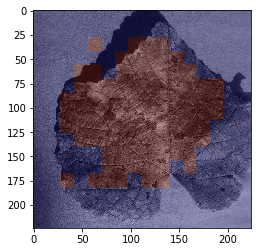

---------------------------------------------------------------------------------------------
Label pneumonia: 10
(256, 256)


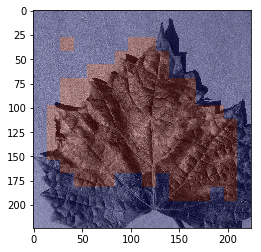

---------------------------------------------------------------------------------------------
Label pneumonia: 10
(256, 256)


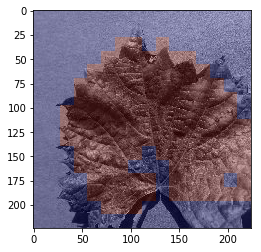

---------------------------------------------------------------------------------------------
Label pneumonia: 10
(256, 256)


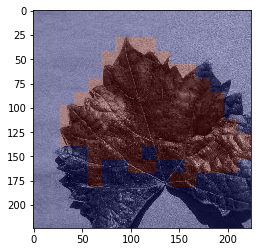

---------------------------------------------------------------------------------------------
Label pneumonia: 11
(256, 256)


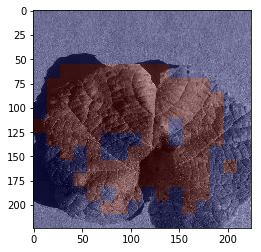

---------------------------------------------------------------------------------------------
Label pneumonia: 10
(256, 256)


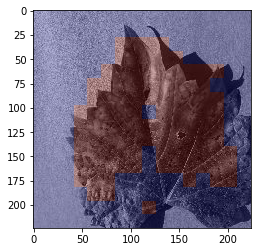

---------------------------------------------------------------------------------------------
Label pneumonia: 11
(256, 256)


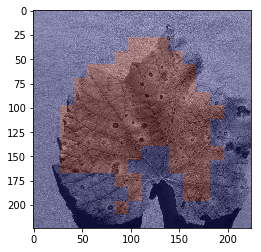

---------------------------------------------------------------------------------------------
Label pneumonia: 10
(256, 256)


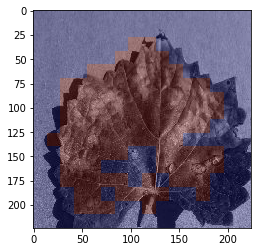

---------------------------------------------------------------------------------------------
Label pneumonia: 11
(256, 256)


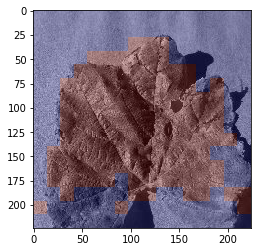

---------------------------------------------------------------------------------------------
Label pneumonia: 10
(256, 256)


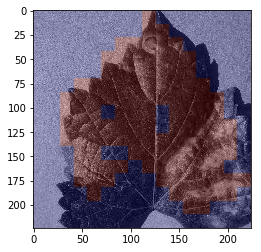

---------------------------------------------------------------------------------------------
Label pneumonia: 10
(256, 256)


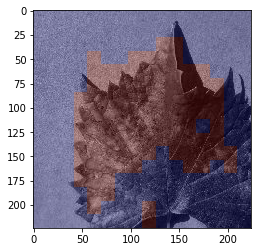

---------------------------------------------------------------------------------------------


In [41]:
print ("The following are the visualizations of the incorrect prediction followed by the same image with ground truth to see the difference:")
for i in range(len(image_mistake_predicted)):
    #print (image_mistake[i])
    plot_grid_over_xray(image_mistake_predicted[i])
    plot_
#     img = read_image(path_to_image_folder+"/"+label_names_dataset[i[2]]+"/"+img, 256)
#     img = draw_boxes(img, i[3])
#     print (i[4])
#     img = draw_text(img, label_names_dataset[i[2]], i[3])
#     plt.imshow(img)
#     plt.show()
    print ("---------------------------------------------------------------------------------------------")